<a href="https://colab.research.google.com/github/skpatel0813/keyword-KeyPhraseExtraction/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TF-IDF

In [ ]:
# PART 1: Setup and Load Data
from pathlib import Path
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path
DATA_DIR = Path('/content/drive/MyDrive/cs7267-sp25/cs7267-sp25')

# Chapter file mapping
train_chapters = [1, 2, 3, 4, 5, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19]
test_chapters = [6, 10, 11, 12]

def load_chapters(chapter_nums):
    texts = []
    for ch in chapter_nums:
        ch_path = DATA_DIR / f'ch{ch}.txt'
        if ch_path.exists():
            with open(ch_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
        else:
            print(f"[!] Chapter file not found: {ch_path}")
    return texts

train_texts = load_chapters(train_chapters)
test_texts = load_chapters(test_chapters)

# Load index terms
with open(DATA_DIR / 'index.txt', 'r', encoding='utf-8') as f:
    index_terms = [line.strip().lower() for line in f if line.strip()]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PART 2: Preprocessing and Phrase Extraction

# Install spaCy and download English model
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from spacy.matcher import Matcher
from collections import Counter
import re

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define noun phrase pattern
matcher = Matcher(nlp.vocab)
pattern = [{'POS': 'ADJ', 'OP': '?'}, {'POS': 'NOUN'}, {'POS': 'NOUN', 'OP': '?'}]
matcher.add("NOUN_PHRASE", [pattern])

# Manual stopwords (to remove generic terms)
manual_stopwords = {
    'time', 'value', 'example', 'figure', 'number', 'code', 'set', 'chapter',
    'step', 'output', 'input', 'state', 'instance', 'class'
}

# CamelCase splitter
def split_camel_case(phrase):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

# Main function to extract and clean phrases
def extract_candidate_phrases(text):
    doc = nlp(text)
    matches = matcher(doc)
    phrases = []
    for match_id, start, end in matches:
        span = doc[start:end]
        phrase = span.text.strip()
        phrase = split_camel_case(phrase)                 # split CamelCase
        phrase = phrase.lower()                           # lowercase
        phrase = re.sub(r'[^a-zA-Z0-9\s\-]', '', phrase)  # remove punctuation
        phrase = phrase.strip()

        if (phrase
            and len(phrase.split()) >= 1
            and len(phrase.split()) <= 5
            and phrase not in nlp.Defaults.stop_words
            and phrase not in manual_stopwords):
            phrases.append(phrase)
    return phrases

# Extract phrases from all training chapters
train_candidates = []
for text in train_texts:
    phrases = extract_candidate_phrases(text)
    train_candidates.extend(phrases)

# Count frequency
top_phrases = Counter(train_candidates).most_common(30)
print("Top cleaned candidate keyphrases:")
for phrase, count in top_phrases:
    print(f"{phrase} ({count})")


Top cleaned candidate keyphrases:
model (987)
training (695)
layer (559)
data (522)
function (380)
dataset (373)
instances (287)
layers (263)
keraslayers (244)
images (230)
image (222)
feature (212)
features (191)
values (182)
network (178)
method (170)
training set (164)
action (161)
classifier (159)
inputs (157)
learning (156)
batch (153)
word (152)
import (152)
predictions (149)
models (142)
size (139)
parameters (137)
vector (135)
steps (132)


In [ ]:
# --- STEP 1: Label candidate phrases using index.txt ---
import spacy
from collections import Counter

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load and normalize index terms
with open(DATA_DIR / 'index.txt', 'r', encoding='utf-8') as f:
    index_terms = [line.strip().lower() for line in f if line.strip()]

def lemmatize_phrase(phrase):
    doc = nlp(phrase)
    return " ".join([
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha
    ])

# Lemmatized index terms set
lemmatized_index_set = set([lemmatize_phrase(term) for term in index_terms])

# Unique candidate phrases from training
phrase_counts = Counter(train_candidates)
phrases = list(phrase_counts.keys())  # Unique phrases

# Label each phrase: 1 = concept, 0 = not concept
labels = [1 if lemmatize_phrase(p) in lemmatized_index_set else 0 for p in phrases]
y = np.array(labels)

print(f"Labeled {sum(y)} positive keyphrases out of {len(y)} total candidates")


Labeled 1252 positive keyphrases out of 12009 total candidates


In [ ]:
# --- STEP 2: Feature Extraction ---
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Define handcrafted features
def phrase_features(phrase):
    words = phrase.split()
    tf = phrase_counts[phrase]
    length = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    starts_with_verb = int(nlp(words[0])[0].pos_ == 'VERB') if words else 0
    return [tf, length, avg_word_len, starts_with_verb]

# TF-IDF features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.85)
X_tfidf = vectorizer.fit_transform(phrases)

# Handcrafted features
X_handcrafted = np.array([phrase_features(p) for p in phrases])

# Combine features
X = hstack([X_tfidf, X_handcrafted])

# Sanity check
print("Feature matrix shape:", X.shape)
print("Label vector shape:  ", y.shape)


Feature matrix shape: (12009, 4134)
Label vector shape:   (12009,)


In [ ]:
# --- STEP 3: Train and Evaluate Logistic Regression ---
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier with class balancing
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_val)
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=['Not Concept', 'Concept']))


Classification Report:

              precision    recall  f1-score   support

 Not Concept       0.94      0.82      0.87      2150
     Concept       0.26      0.54      0.35       252

    accuracy                           0.79      2402
   macro avg       0.60      0.68      0.61      2402
weighted avg       0.87      0.79      0.82      2402



In [ ]:
# Reuse previous phrase extraction for test chapters
test_candidates = []
for text in test_texts:
    phrases = extract_candidate_phrases(text)
    test_candidates.extend(phrases)

# Deduplicate
test_candidates = list(set(test_candidates))

# Create feature matrix for test phrases
X_test = np.array([phrase_features(p) for p in test_candidates])

# Predict with trained model
test_preds = clf.predict(X_test)

# Filter predicted keyphrases
predicted_concepts = [p for p, pred in zip(test_candidates, test_preds) if pred == 1]
print(f"Extracted {len(predicted_concepts)} predicted key concepts from test chapters.")


Extracted 1796 predicted key concepts from test chapters.


In [ ]:
from itertools import combinations
from collections import defaultdict
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

# Co-occurrence map: concept pairs within same sentence
co_occurrence_edges = defaultdict(int)

for text in test_texts:
    sentences = sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        present_concepts = [c for c in predicted_concepts if c in sent]
        for c1, c2 in combinations(set(present_concepts), 2):
            pair = tuple(sorted([c1, c2]))
            co_occurrence_edges[pair] += 1

# Filter pairs with at least N co-occurrences
min_threshold = 2
final_edges = {pair: count for pair, count in co_occurrence_edges.items() if count >= min_threshold}

print(f"Found {len(final_edges)} concept pairs with co-occurrence >= {min_threshold}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 65545 concept pairs with co-occurrence >= 2


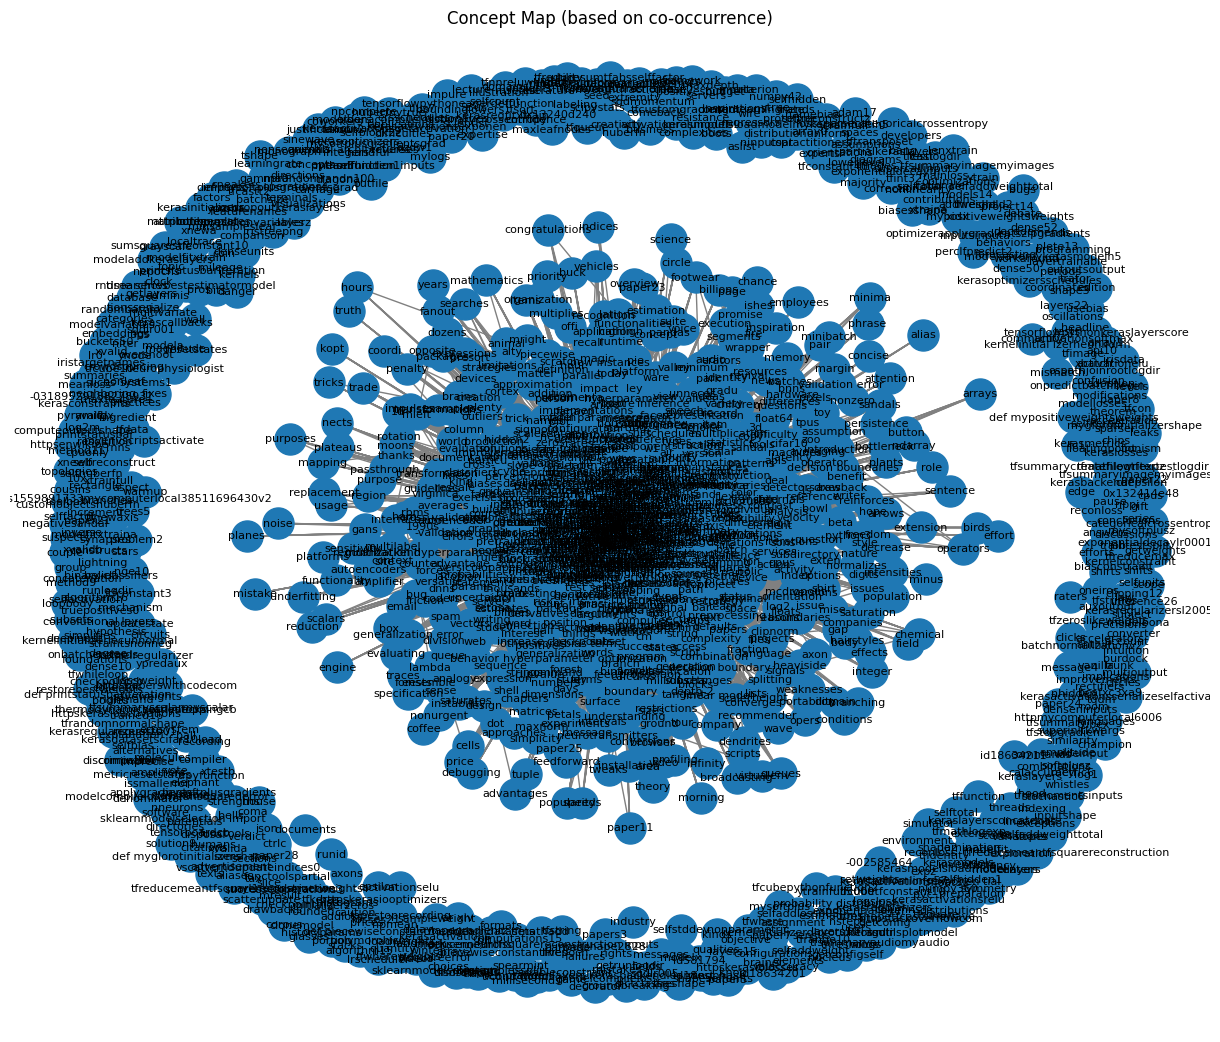

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build undirected graph
G = nx.Graph()

# Add nodes
for concept in predicted_concepts:
    G.add_node(concept)

# Add edges with weights
for (c1, c2), weight in final_edges.items():
    G.add_edge(c1, c2, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("Concept Map (based on co-occurrence)")
plt.show()


RAKE

In [ ]:
# --- PART 1: RAKE Concept Extraction ---
!pip install -q rake-nltk

from rake_nltk import Rake
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re

# Download stopwords
nltk.download('stopwords')

# Initialize RAKE
rake = Rake(
    stopwords=stopwords.words('english'),
    min_length=2,
    max_length=4
)

# Combine all training text into one block
full_train_text = " ".join(train_texts)

# Extract ranked phrases
rake.extract_keywords_from_text(full_train_text)
rake_results = rake.get_ranked_phrases_with_scores()

# Filter and clean phrases
min_score_threshold = 3.0
filtered_phrases = [
    phrase.lower().strip()
    for score, phrase in rake_results
    if score >= min_score_threshold
    and phrase.strip()
    and not re.search(r'\d', phrase)
    and len(phrase.split()) <= 4
]

# Remove phrases that are all stopwords
stop_set = set(stopwords.words('english'))
filtered_phrases = [
    phrase for phrase in filtered_phrases
    if any(word not in stop_set for word in phrase.split())
]

# Deduplicate and keep top-N
TOP_N = 300
extracted_phrases = list(dict.fromkeys(filtered_phrases))[:TOP_N]

print(f"\nTop {len(extracted_phrases)} RAKE phrases:\n")
for phrase in extracted_phrases[:20]:
    print("-", phrase)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 300 RAKE phrases:

- fan temp perf pwr
- shuai li et al
- samy bengio et al
- rico sennrich et al
- peter norvig et al
- malvina nissim et al
- le et al .’
- kyunghyun cho et al
- césar laurent et al
- christian szegedy et al
- adriana kovashka et al
- trajecto ‐ ries recorded
- technol ‐ ogies evolve
- fool unsus ‐ pecting
- convoluted distri ‐ bution
- dynamic_step_driver import dynamicstepdriver collect_driver
- mark schmidt et al
- seeks situa ‐ tions
- grad ‐ ually lose
- careful seeding ,” proceedings


In [ ]:
# --- PART 2: Partial Match Evaluation ---
from sklearn.metrics import precision_score, recall_score, f1_score

# Lowercased index and prediction sets
index_set = set(t.lower().strip() for t in index_terms)
predicted_set = set(p.lower().strip() for p in extracted_phrases)

# Partial match function
def partial_match(pred, gold_terms):
    return any(pred in g or g in pred for g in gold_terms)

# Count matches
true_positives = [p for p in predicted_set if partial_match(p, index_set)]
TP = len(true_positives)
FP = len(predicted_set) - TP
FN = len(index_set) - TP

# Metrics
precision = TP / (TP + FP) if (TP + FP) else 0
recall = TP / (TP + FN) if (TP + FN) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print("\nPartial Match Evaluation:")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")



Partial Match Evaluation:
True Positives: 1
False Positives: 299
False Negatives: 1267

Precision: 0.0033
Recall:    0.0008
F1-Score:  0.0013


In [ ]:
# Extract concepts from test chapters
test_phrases = []
for text in test_texts:
    rake.extract_keywords_from_text(text)
    test_phrases += rake.get_ranked_phrases()

# Keep top N
test_phrases = list(set([p.lower() for p in test_phrases]))[:300]  # you can adjust number
print(f"Extracted {len(test_phrases)} phrases from test chapters.")


Extracted 300 phrases from test chapters.


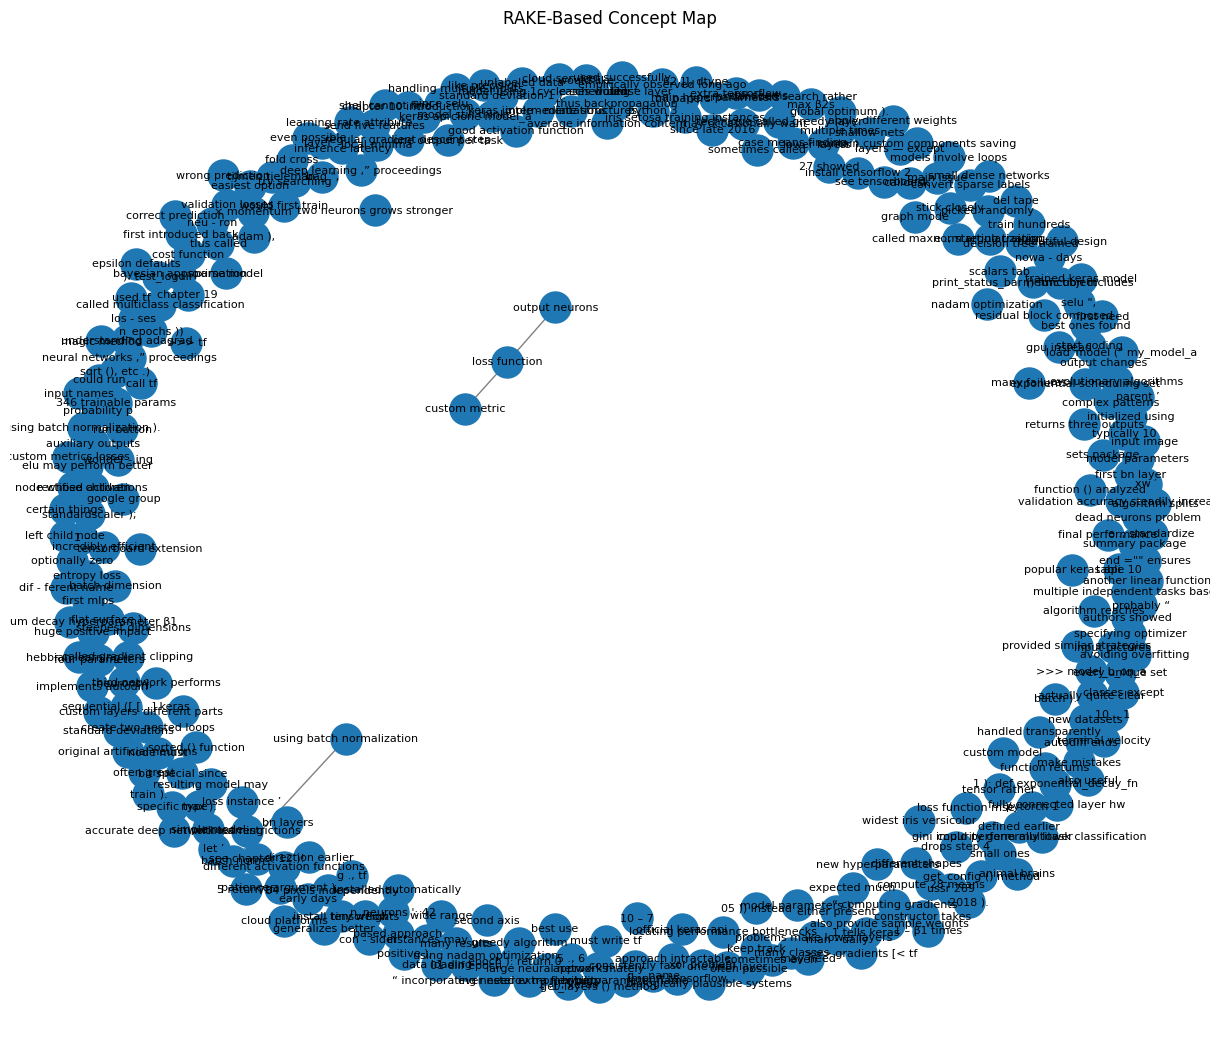

In [ ]:
import networkx as nx
from nltk import sent_tokenize
from itertools import combinations
from collections import defaultdict

co_occurrence_edges = defaultdict(int)

# Check co-occurrence in same sentence
for text in test_texts:
    for sent in sent_tokenize(text):
        sent = sent.lower()
        present = [p for p in test_phrases if p in sent]
        for c1, c2 in combinations(set(present), 2):
            pair = tuple(sorted([c1, c2]))
            co_occurrence_edges[pair] += 1

# Filter weak edges
min_threshold = 2
final_edges = {pair: count for pair, count in co_occurrence_edges.items() if count >= min_threshold}

# Build graph
G = nx.Graph()
for concept in test_phrases:
    G.add_node(concept)
for (c1, c2), w in final_edges.items():
    G.add_edge(c1, c2, weight=w)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("RAKE-Based Concept Map")
plt.show()
